# Model based on sentence features
***
Libraries:

In [0]:
!pip install transformers
!pip install -q pyyaml h5py
import pandas as pd
from transformers import *
import numpy as np
from sklearn.model_selection import train_test_split


## Data preprocessing 
- reading data 
- change columns names 
- drop NaN rows 
- fill others NaN values by special sign

In [0]:
df = pd.read_excel('dataset3.xlsx')
df.reset_index()
df = df.iloc[:,[2,3,5,8,9,11,12,13]]
df.columns = ["verb_veridial_positive",
              "verb_veridical_negative",
              "semantic_characteristic",
              "standford_signature_for_that",
              "standford_signature_for_to",
              "complementizer",
              "verb_tense",
              "semantic_relation"]
df.dropna(inplace=True, axis = 0, how = 'all')
df.fillna(axis = 0, inplace =True, value="none")
df.head()

,verb_veridial_positive,verb_veridical_negative,semantic_characteristic,standford_signature_for_that,standford_signature_for_to,complementizer,verb_tense,semantic_relation
0,o,o,epistemiczny,o/o,none,that,present,N
1,o,o,emotywny,none,none,that,present,N
2,o,o,mówienia,nie ma,none,that,present,N
3,o,o,epistemiczny,o/o,none,that,present,N
4,o,o,epistemiczny,nie ma,none,that,past,E


### cleaning data by deleting uncertainty - simplification 


In [0]:
#verb veridical positive cleaning
df.verb_veridial_positive = df.verb_veridial_positive.apply(lambda x: '+' if '+' in x else x)
df.verb_veridial_positive = df.verb_veridial_positive.apply(lambda x: '-' if '-' in x else x)
df.verb_veridial_positive = df.verb_veridial_positive.apply(lambda x: 'o' if 'o' in x else x)
df.verb_veridial_positive = df.verb_veridial_positive.apply(lambda x: '?' if '?' in x else x)

#verb veridical negative cleaning
df.verb_veridical_negative = df.verb_veridical_negative.apply(lambda x: '+' if '+' in x else x)
df.verb_veridical_negative = df.verb_veridical_negative.apply(lambda x: 'o' if 'o' in x else x)
df.verb_veridical_negative = df.verb_veridical_negative.apply(lambda x: '-' if '-' in x else x)
df.verb_veridical_negative = df.verb_veridical_negative.apply(lambda x: '1' if '1' in x else x)
df.verb_veridical_negative = df.verb_veridical_negative.apply(lambda x: '?' if '?' in x else x)

#df.semantic_characteristic.unique() cleaning not needed
#df.standford_signature_for_that.unique() cleaning not needed
#df.standford_signature_for_to.unique() cleaning not needed
#df.complementizer.unique() cleaning not needed

#df.verb_tense cleaning
df.verb_tense = df.verb_tense.apply(lambda x: 'present' if 'present' in x else x)
df.verb_tense = df.verb_tense.apply(lambda x: 'past' if 'past' in x else x)
df.verb_tense = df.verb_tense.apply(lambda x: 'future' if 'future' in x else x)
df.verb_tense = df.verb_tense.apply(lambda x: 'none' if 'none' in x else x)
df.verb_tense = df.verb_tense.apply(lambda x: '?' if '?' in x else x)

df.head()

,verb_veridial_positive,verb_veridical_negative,semantic_characteristic,standford_signature_for_that,standford_signature_for_to,complementizer,verb_tense,semantic_relation
0,o,o,epistemiczny,o/o,none,that,present,N
1,o,o,emotywny,none,none,that,present,N
2,o,o,mówienia,nie ma,none,that,present,N
3,o,o,epistemiczny,o/o,none,that,present,N
4,o,o,epistemiczny,nie ma,none,that,past,E


In [0]:
print(df.verb_veridial_positive.unique())
print(df.verb_veridical_negative.unique())
print(df.semantic_characteristic.unique())
print(df.standford_signature_for_that.unique())
print(df.standford_signature_for_to.unique())
print(df.complementizer.unique())
print(df.verb_tense.unique())
print(df.semantic_relation.unique())

['o' '+' '-' '?']
['o' '+' '-' '?' '1']
['epistemiczny' 'emotywny' 'mówienia' 'ontyczny' 'wynikania'
 'określające dostęp do wiedzy' 'percepcyjny' 'pamięciowy' 'odkrycia'
 'czynnościowy' 'epistemiczno-percepcyjny' 'pokazywania' 'dowodzenia'
 'mówieniowo-pamięciowy' 'liczenia' 'wnioskowania'
 'percepcyjno-mówieniowy' 'zdarzeniowy']
['o/o' 'none' 'nie ma' '"+/o"' '"+/+"' 'o/+']
['none' 'o/o']
['that' 'to']
['present' 'past' 'none' 'future' '?']
['N' 'E' '?' 'C']


In [0]:
df.to_csv("engData.csv", index=False)

### vectorize data and split to features and target

In [0]:
df = pd.get_dummies(df)

X_train = df.iloc[:,1:-4]
y_train = df.iloc[:,-4:]

X_train.head()

,verb_veridial_positive_-,verb_veridial_positive_?,verb_veridial_positive_o,verb_veridical_negative_+,verb_veridical_negative_-,verb_veridical_negative_1,verb_veridical_negative_?,verb_veridical_negative_o,semantic_characteristic_czynnościowy,semantic_characteristic_dowodzenia,semantic_characteristic_emotywny,semantic_characteristic_epistemiczno-percepcyjny,semantic_characteristic_epistemiczny,semantic_characteristic_liczenia,semantic_characteristic_mówienia,semantic_characteristic_mówieniowo-pamięciowy,semantic_characteristic_odkrycia,semantic_characteristic_określające dostęp do wiedzy,semantic_characteristic_ontyczny,semantic_characteristic_pamięciowy,semantic_characteristic_percepcyjno-mówieniowy,semantic_characteristic_percepcyjny,semantic_characteristic_pokazywania,semantic_characteristic_wnioskowania,semantic_characteristic_wynikania,semantic_characteristic_zdarzeniowy,"standford_signature_for_that_""+/+""","standford_signature_for_that_""+/o""",standford_signature_for_that_nie ma,standford_signature_for_that_none,standford_signature_for_that_o/+,standford_signature_for_that_o/o,standford_signature_for_to_none,standford_signature_for_to_o/o,complementizer_that,complementizer_to,verb_tense_?,verb_tense_future,verb_tense_none,verb_tense_past,verb_tense_present
0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,1,0,0,0,0,0,1
1,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0,1
2,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,1
3,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,1,0,0,0,0,0,1
4,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,1,0


In [0]:
X_train.columns

Index(['verb_veridial_positive_-', 'verb_veridial_positive_?',
       'verb_veridial_positive_o', 'verb_veridical_negative_+',
       'verb_veridical_negative_-', 'verb_veridical_negative_1',
       'verb_veridical_negative_?', 'verb_veridical_negative_o',
       'semantic_characteristic_czynnościowy',
       'semantic_characteristic_dowodzenia',
       'semantic_characteristic_emotywny',
       'semantic_characteristic_epistemiczno-percepcyjny',
       'semantic_characteristic_epistemiczny',
       'semantic_characteristic_liczenia', 'semantic_characteristic_mówienia',
       'semantic_characteristic_mówieniowo-pamięciowy',
       'semantic_characteristic_odkrycia',
       'semantic_characteristic_określające dostęp do wiedzy',
       'semantic_characteristic_ontyczny',
       'semantic_characteristic_pamięciowy',
       'semantic_characteristic_percepcyjno-mówieniowy',
       'semantic_characteristic_percepcyjny',
       'semantic_characteristic_pokazywania',
       'semantic_charact

In [0]:
y_train.head()

,semantic_relation_?,semantic_relation_C,semantic_relation_E,semantic_relation_N
0,0,0,0,1
1,0,0,0,1
2,0,0,0,1
3,0,0,0,1
4,0,0,1,0


***
# Keras model building

In [0]:
import tensorflow as tf 
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense

In [0]:
model = tf.keras.Sequential()

#get number of columns in training data
n_cols = X_train.shape[1]
print(n_cols)
#add model layers
model.add(Dense(100, activation=keras.layers.LeakyReLU(alpha=0.3), input_shape=(n_cols,)))
model.add(Dense(250, activation='relu'))
model.add(Dense(500, activation=keras.layers.LeakyReLU(alpha=0.3)))
model.add(Dense(250, activation='selu'))
model.add(Dense(100, activation=keras.layers.LeakyReLU(alpha=0.3)))
model.add(Dense(50, activation=keras.layers.LeakyReLU(alpha=0.3)))
model.add(Dense(4, activation='softmax'))

model.compile(optimizer = 'adam', loss="categorical_crossentropy", metrics = ['accuracy'])
model.summary()

41
Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_35 (Dense)             (None, 100)               4200      
_________________________________________________________________
dense_36 (Dense)             (None, 250)               25250     
_________________________________________________________________
dense_37 (Dense)             (None, 500)               125500    
_________________________________________________________________
dense_38 (Dense)             (None, 250)               125250    
_________________________________________________________________
dense_39 (Dense)             (None, 100)               25100     
_________________________________________________________________
dense_40 (Dense)             (None, 50)                5050      
_________________________________________________________________
dense_41 (Dense)             (None, 4)             

## Training model on prepared data

In [0]:
#train model
history = model.fit(X_train, y_train, validation_split=0.4, epochs=30)

Epoch 1/30
42/42 [==============================] - 0s 10ms/step - loss: 0.5196 - accuracy: 0.8474 - val_loss: 0.4843 - val_accuracy: 0.8565
Epoch 2/30
42/42 [==============================] - 0s 7ms/step - loss: 0.3902 - accuracy: 0.8808 - val_loss: 0.4513 - val_accuracy: 0.8679
Epoch 3/30
42/42 [==============================] - 0s 8ms/step - loss: 0.3734 - accuracy: 0.8914 - val_loss: 0.4616 - val_accuracy: 0.8679
Epoch 4/30
42/42 [==============================] - 0s 8ms/step - loss: 0.3631 - accuracy: 0.8945 - val_loss: 0.4668 - val_accuracy: 0.8690
Epoch 5/30
42/42 [==============================] - 0s 8ms/step - loss: 0.3569 - accuracy: 0.8907 - val_loss: 0.4602 - val_accuracy: 0.8610
Epoch 6/30
42/42 [==============================] - 0s 7ms/step - loss: 0.3413 - accuracy: 0.8960 - val_loss: 0.4561 - val_accuracy: 0.8679
Epoch 7/30
42/42 [==============================] - 0s 7ms/step - loss: 0.3285 - accuracy: 0.8967 - val_loss: 0.4583 - val_accuracy: 0.8724
Epoch 8/30
42/42 [=

## plot with train and test accuracy

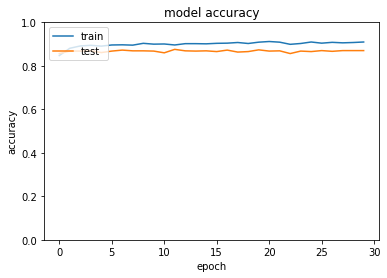

In [0]:
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.ylim(0,1)
plt.legend(['train', 'test'], loc='upper left')
plt.show()

### Save model 


In [0]:
model.save('featureModelEng.h5')

## Load model example

In [0]:
model2 = tf.keras.models.load_model('my_model.h5',custom_objects={'LeakyReLU': keras.layers.LeakyReLU })
model2.summary()
print(model2.evaluate(X_train, y_train))